# 🏠 Homework: Predicting Airbnb Listing Prices

**Your mission:** Clean and analyze a real-world Airbnb dataset, and build a model to predict listing prices.

This dataset contains dirty, messy, and surprising data — just like real life. Your job is to:

1. **Explore and clean the data**
2. **Engineer meaningful features**
3. **Split into train/test sets**
4. **Build and evaluate a linear regression model**
5. **Interpret your results**


## 🔍 Part A: Load and Explore

1. Load the CSV file `airbnb_dirty_mock.csv`
2. View column names, data types, and general structure
3. Plot a histogram of `price`
4. What issues or red flags do you immediately notice?

In [22]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV, RFE

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

 # This is to avoid the SettingWithCopyWarning in pandas
 # https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True

NumPy version: 2.3.1
Pandas version: 2.3.1


In [23]:


csv_url = 'https://www.dropbox.com/scl/fi/gvg9vt3lcnh1807q0enlm/airbnb_dirty.csv?rlkey=x2q13wifq69djvu85zmsof530&dl=1'
csv_file = 'airbnb_dirty.csv'

if not os.path.exists(csv_file):
    !wget -O "$csv_file" "$csv_url"


df = pd.read_csv(csv_file)

display(df)

,id,name,host_name,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,host_phone,has_wifi
0,1001,Listing 0,Host0,10001,SHARED ROOM,142,3,64,2022-11-26 00:00:00,1.71,123-456-7890,f
1,1002,Listing 1,Host1,11231,ENTIRE HOME/APT,31,17,7,2022-03-15 00:00:00,1.55,NaN,t
2,1003,Listing 2,Host2,10009,PRIVATE ROOM,159,1,143,2022-04-26 00:00:00,3.13,NaN,f
3,1004,Listing 3,Host3,11211,ENTIRE HOME/APT,249,16,141,2022-07-26 00:00:00,1.43,NaN,f
4,1005,Listing 4,Host4,11101,SHARED ROOM,83,12,114,2021-12-28 00:00:00,3.73,NaN,f
...,...,...,...,...,...,...,...,...,...,...,...,...
97,1098,Listing 97,Host97,Brooklyn,Entire home/apt,306,4,189,2021-06-23 00:00:00,3.81,NaN,t
98,1099,Listing 98,Host98,Brooklyn,Entire home/apt,333,13,196,2021-08-12 00:00:00,3.57,NaN,t
99,1100,Listing 99,Host99,Manhattan,Shared room,164,20,143,2023-03-25 00:00:00,1.88,NaN,t
100,1001,Listing 0,Host0,Bronx,Shared room,142,3,64,2022-11-26 00:00:00,1.71,123-456-7890,t


In [24]:
print(df.columns, df.shape)

df.describe()

Index(['id', 'name', 'host_name', 'neighbourhood_group', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'host_phone', 'has_wifi'],
      dtype='object') (102, 12)


,id,minimum_nights,number_of_reviews
count,102.000000,102.000000,102.000000
mean,1049.539216,15.676471,99.892157
std,29.523165,9.113326,55.901594
min,1001.000000,1.000000,0.000000
25%,1024.250000,7.250000,57.000000
50%,1049.500000,17.000000,97.500000
75%,1074.750000,23.000000,143.000000
max,1100.000000,29.000000,196.000000


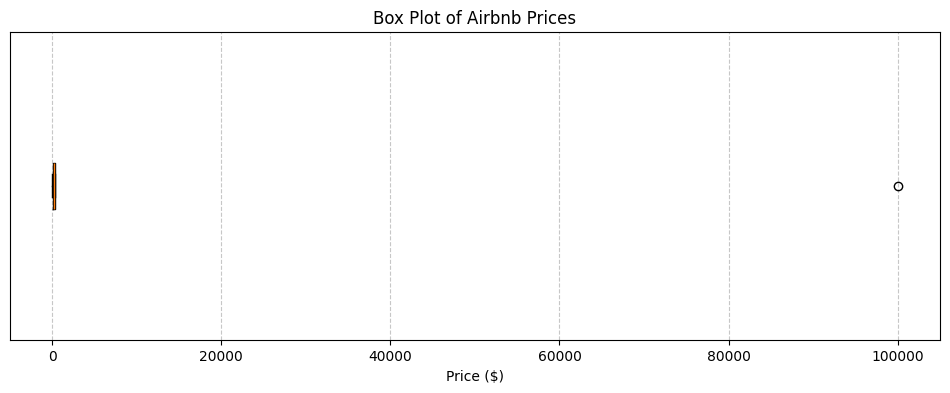

In [25]:
price_series = df['price'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float).dropna()

# --- Plotting a Box Plot to Visualize Outliers ---
plt.figure(figsize=(12, 4))
plt.boxplot(price_series, vert=False)
plt.title('Box Plot of Airbnb Prices')
plt.xlabel('Price ($)')
plt.yticks([]) # Hide y-axis ticks for clarity
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('price_boxplot.png')

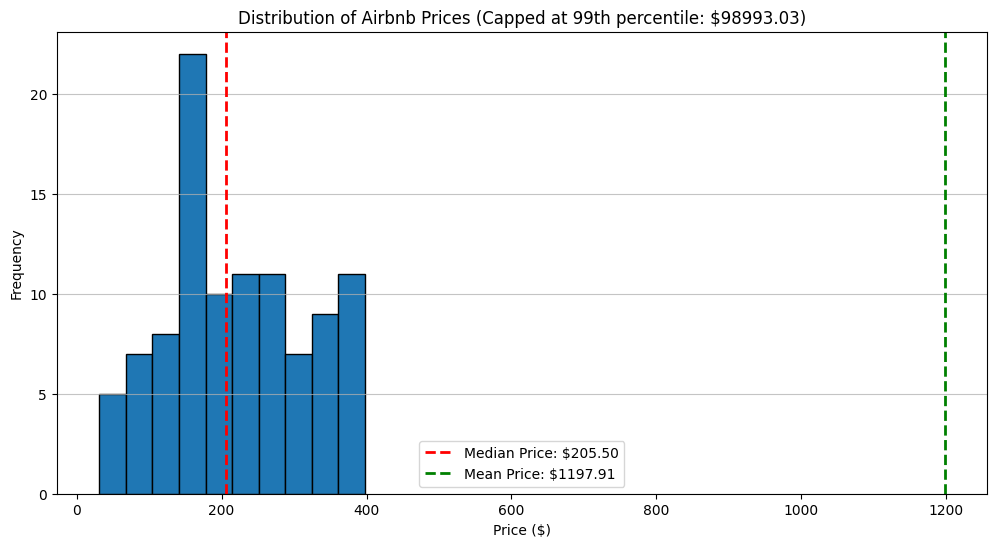

In [26]:
p9999 = price_series.quantile(0.9999)
capped_prices = price_series[price_series <= p9999]

# Use a standard rule (e.g., Sturges' rule) for a reasonable number of bins
# num_bins_capped = int(np.ceil(1 + np.log2(len(capped_prices))))


# --- Plotting a More Informative Capped Histogram ---
plt.figure(figsize=(12, 6))
plt.hist(capped_prices, bins=10, edgecolor='black')
plt.title(f'Distribution of Airbnb Prices (Capped at 99th percentile: ${p9999:.2f})')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# Add lines for mean and median to show skewness
plt.axvline(price_series.median(), color='red', linestyle='dashed', linewidth=2, label=f'Median Price: ${price_series.median():.2f}')
plt.axvline(price_series.mean(), color='green', linestyle='dashed', linewidth=2, label=f'Mean Price: ${price_series.mean():.2f}')

plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.savefig('price_histogram_capped.png')

## 🧹 Part B: Data Cleaning

**Clean your dataset to make it ready for modeling.** Consider the following steps:
- Fix or convert `price` to numeric
- Convert `last_review` to datetime (hint: use `errors='coerce'`)
- Handle invalid or missing data in `reviews_per_month`
- Drop columns that are not useful (e.g., `host_name`, `host_phone`, or duplicates)
- Handle duplicate rows
- Make sure categorical values are consistent (e.g. whitespace in `room_type`)

In [27]:
# Remove " USD" and "$" using a regular expression
df['price'] = df['price'].str.replace(' USD|\\$', '', regex=True)

# Convert to numeric, raise error if unable to convert values
df['price'] = pd.to_numeric(df['price'], errors='raise')
print(f"{len(df['price'][df['price'] < p9999].dropna())}")
df = df[df['price'] < p9999].dropna(subset=['price'])

display(df[[ 'price']])

101


,price
0,142.0
1,31.0
2,159.0
3,249.0
4,83.0
...,...
97,306.0
98,333.0
99,164.0
100,142.0


In [28]:
def find_missing_rows(df1, df2):
    """
    Finds rows that exist in df1 but not in df2.
    This comparison is based on all columns.
    """
    # An outer merge aligns the two DataFrames. The indicator shows the source of each row.
    merged_df = df1.merge(df2, how='outer', indicator=True)
    
    # Filter for rows that are exclusive to the left DataFrame (df1).
    missing_rows_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
    print(f"Missing rows columns: {missing_rows_df.columns}, shape: {missing_rows_df.shape}")
    return missing_rows_df


In [29]:
# Clean column names of any whitespace
df.columns = df.columns.str.strip()

# Remove columns, then rows that are not useful
# This will improve performance of operations on large datasets
df = df.drop(columns=['name', 'host_name', 'host_phone'])

df_before = df

# Remove latter occurrence of rows with duplicates in the 'id' column
df = df.drop_duplicates(subset=['id'])

display(find_missing_rows(df_before, df))


Missing rows columns: Index(['id', 'neighbourhood_group', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month', 'has_wifi'],
      dtype='object'), shape: (2, 9)


,id,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,has_wifi
1,1001,Bronx,Shared room,142.0,3,64,2022-11-26 00:00:00,1.71,t
3,1002,Staten Island,Entire home/apt,31.0,17,7,2022-03-15 00:00:00,1.55,f


In [30]:
# Convert to datetime and then to initial Unix timestamps (int64).
# Invalid dates become the integer -9223372037.
temp_series_int = pd.to_datetime(df['last_review'], errors='coerce').astype(np.int64) // 10**9

# To calculate the median correctly, make a float copy and replace the NaT integer with np.nan.
# This step is isolated and does not affect the final integer column.
temp_series_for_median = temp_series_int.replace({-9223372037: np.nan})
median_timestamp = temp_series_for_median.median() # This calculates the median as a float.

# Go back to the original integer series and replace the NaT placeholder.
# Convert the calculated float median to an integer before replacing.
df['last_review'] = temp_series_int.replace({-9223372037: int(median_timestamp)})

display(df)

,id,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,has_wifi
0,1001,10001,SHARED ROOM,142.0,3,64,1669420800,1.71,f
1,1002,11231,ENTIRE HOME/APT,31.0,17,7,1647302400,1.55,t
2,1003,10009,PRIVATE ROOM,159.0,1,143,1650931200,3.13,f
3,1004,11211,ENTIRE HOME/APT,249.0,16,141,1658793600,1.43,f
4,1005,11101,SHARED ROOM,83.0,12,114,1640649600,3.73,f
...,...,...,...,...,...,...,...,...,...
95,1096,Queens,Entire home/apt,97.0,7,46,1608768000,0.28,t
96,1097,Staten Island,Entire home/apt,318.0,25,93,1671667200,1.2,f
97,1098,Brooklyn,Entire home/apt,306.0,4,189,1624406400,3.81,t
98,1099,Brooklyn,Entire home/apt,333.0,13,196,1628726400,3.57,t


In [31]:
# Clean 'room_type' column by removing leading/trailing whitespace and converting to lowercase
df['room_type'] = df['room_type'].str.strip().str.lower()

df['room_type'].value_counts()


room_type
shared room        37
entire home/apt    35
private room       27
Name: count, dtype: int64

In [32]:
import pgeocode

nomi = pgeocode.Nominatim('us')

def convert_zip_to_city(value, nomi):
    """
    Conditionally converts a zip code to a city name.
    - If the value is not a 5-digit number, it's returned as is.
    - If the value is a zip code, it's converted to a city name.
    """
    # Convert value to string to handle potential mixed types
    s_value = str(value).strip()

    # Check if the value is a 5-digit number (a likely zip code)
    if s_value.isdigit() and len(s_value) == 5:
        try:
            # Query for the location data of the zip code
            location_info = nomi.query_postal_code(s_value)
            
            # pgeocode returns NaN for invalid codes, so check for that
            if pd.isna(location_info.place_name):
                return value # Return original value if zip is not found

            city = location_info['place_name']
            zip_code = location_info['postal_code']

           
            # Conditional replacement for 'New York'
            if city == 'New York':
                # TODO: handle more cities with alternative names
                alternative_city_name = 'Manhattan'
                print(f"Converting zip code {zip_code} to city: {alternative_city_name}")
                return alternative_city_name
            elif city == 'Long Island City':
                alternative_city_name = 'Queens'
                print(f"Converting zip code {zip_code} to city: {alternative_city_name}")
                return alternative_city_name
            else:
                print(f"Converting zip code {zip_code} to city: {city}")
                return city
        except Exception:
            # If any error occurs during lookup, return the original value
            return value
    else:
        # If it's not a 5-digit number (e.g., "Queens", "Brooklyn"), return it unchanged
        return value

# Apply the updated function to the 'neighbourhood_group' column
df['neighbourhood_group'] = df['neighbourhood_group'].apply(lambda x: convert_zip_to_city(x, nomi))

df['neighbourhood_group'].value_counts()

Converting zip code 10001 to city: Manhattan
Converting zip code 11231 to city: Brooklyn
Converting zip code 10009 to city: Manhattan
Converting zip code 11211 to city: Brooklyn
Converting zip code 11101 to city: Queens
Converting zip code 10002 to city: Manhattan


neighbourhood_group
Bronx            25
Brooklyn         22
Manhattan        21
Staten Island    16
Queens           15
Name: count, dtype: int64

## ⚙️ Part C: Feature Engineering

1. Create `log_price` as the log of the `price` column (use `np.log1p`)
2. One-hot encode `room_type` and `neighbourhood_group`
3. Create a new feature: `reviews_x_freq = number_of_reviews * reviews_per_month`
4. Optionally: Calculate days since `last_review`

In [33]:
df['has_wifi'] = df['has_wifi'].astype(str).str.lower().isin(['true', 't', '1']).astype(int)
display(df[['id', 'has_wifi']])

,id,has_wifi
0,1001,0
1,1002,1
2,1003,0
3,1004,0
4,1005,0
...,...,...
95,1096,1
96,1097,0
97,1098,1
98,1099,1


In [34]:
# Create a new column 'log_price' that contains the natural logarithm of 'price'
df['log_price'] = df['price'].apply(lambda x: np.log1p(x))
df = df.drop(['price'], axis=1)
display(df[['id', 'log_price']])

,id,log_price
0,1001,4.962845
1,1002,3.465736
2,1003,5.075174
3,1004,5.521461
4,1005,4.430817
...,...,...
95,1096,4.584967
96,1097,5.765191
97,1098,5.726848
98,1099,5.811141


In [35]:
# Convert reviews_per_month to numeric, coerce errors, then drop NaN values
df['reviews_per_month'] = pd.to_numeric(df['reviews_per_month'], errors='coerce').copy()
df = df.dropna(subset=['reviews_per_month'])
print(len(df['reviews_per_month']))

# create interaction feature. `reviews_x_freq`
df['reviews_x_freq'] = df['number_of_reviews'] * df['reviews_per_month']

display(df)

98


,id,neighbourhood_group,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,has_wifi,log_price,reviews_x_freq
0,1001,Manhattan,shared room,3,64,1669420800,1.71,0,4.962845,109.44
1,1002,Brooklyn,entire home/apt,17,7,1647302400,1.55,1,3.465736,10.85
2,1003,Manhattan,private room,1,143,1650931200,3.13,0,5.075174,447.59
3,1004,Brooklyn,entire home/apt,16,141,1658793600,1.43,0,5.521461,201.63
4,1005,Queens,shared room,12,114,1640649600,3.73,0,4.430817,425.22
...,...,...,...,...,...,...,...,...,...,...
95,1096,Queens,entire home/apt,7,46,1608768000,0.28,1,4.584967,12.88
96,1097,Staten Island,entire home/apt,25,93,1671667200,1.20,0,5.765191,111.60
97,1098,Brooklyn,entire home/apt,4,189,1624406400,3.81,1,5.726848,720.09
98,1099,Brooklyn,entire home/apt,13,196,1628726400,3.57,1,5.811141,699.72


In [36]:
df['has_wifi'] = df['has_wifi'].astype(str).str.lower().isin(['true', 't', '1']).astype(int)
display(df[['id', 'has_wifi']])

,id,has_wifi
0,1001,0
1,1002,1
2,1003,0
3,1004,0
4,1005,0
...,...,...
95,1096,1
96,1097,0
97,1098,1
98,1099,1


In [37]:
	# Handle categorical features within the loop for each feature set
X = df.drop(columns=['log_price']).copy()
feature_set = X.columns.tolist()

# Identify categorical and numerical features for the current set
numerical_features = [column for column in X.columns if np.issubdtype(X[column].dtype, np.number)]
# Identify categorical features.
categorical_features = [column for column in X.columns if X[column].dtype in ['object', 'category']]
display(f"Numerical features: {numerical_features}")
display(f"Categorical features: {categorical_features}")



# Create the column transformer for one-hot encoding
preprocessor = ColumnTransformer(
		transformers=[
				('num', 'passthrough', numerical_features),
				('cat', OneHotEncoder(handle_unknown='error'), categorical_features)])

"Numerical features: ['id', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'has_wifi', 'reviews_x_freq']"

"Categorical features: ['neighbourhood_group', 'room_type']"

## ✂️ Part D: Train/Test Split

Use `train_test_split` to divide your data:
- 80% training
- 20% testing

Select relevant features for modeling (no ID, name, or original price).

In [38]:
display(X)

,id,neighbourhood_group,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,has_wifi,reviews_x_freq
0,1001,Manhattan,shared room,3,64,1669420800,1.71,0,109.44
1,1002,Brooklyn,entire home/apt,17,7,1647302400,1.55,1,10.85
2,1003,Manhattan,private room,1,143,1650931200,3.13,0,447.59
3,1004,Brooklyn,entire home/apt,16,141,1658793600,1.43,0,201.63
4,1005,Queens,shared room,12,114,1640649600,3.73,0,425.22
...,...,...,...,...,...,...,...,...,...
95,1096,Queens,entire home/apt,7,46,1608768000,0.28,1,12.88
96,1097,Staten Island,entire home/apt,25,93,1671667200,1.20,0,111.60
97,1098,Brooklyn,entire home/apt,4,189,1624406400,3.81,1,720.09
98,1099,Brooklyn,entire home/apt,13,196,1628726400,3.57,1,699.72


## 📈 Part E: Linear Regression Modeling

1. Train a `LinearRegression` model to predict `log_price`
2. Evaluate it on both train and test sets using:
   - RMSE (Root Mean Squared Error)
   - R² (coefficient of determination)
3. Print model coefficients
4. Interpret: Which features have the strongest impact?

In [39]:
# Create the model pipeline
# Add a normalizer

model = Pipeline(steps=[('preprocessor', preprocessor),
												('scaler', MinMaxScaler()),
												('regressor', LinearRegression())])
y = df['log_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using the training data
model.fit(X_train, y_train)
# Make predictions on the test data
y_pred = model.predict(X_test)
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
display(f"R2 score: {r2:.4f}")
display(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")


'R2 score: -0.0332'

'RMSE: 0.4981'

## 🧠 Bonus (Optional)

Try using `PolynomialFeatures` to add interaction terms between some variables.

Does the model improve? Or overfit?

## ✅ Submission Checklist
- [ ] Notebook is clean and readable
- [ ] You handled weird or dirty data
- [ ] You performed EDA
- [ ] You trained and evaluated a regression model
- [ ] You wrote clear comments or markdown explanations